In [1]:
import myFunctions

import time

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


#### Parameter

In [2]:
batch_size = 1
epochs = 100
look_back = 3

#### Read data

In [3]:
dataset, scaler = myFunctions.read_data('sanmateo', processing='minmax')

In [15]:
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
dataset.shape, train_data.shape, test_data.shape

((37153, 1), (24892, 1), (12261, 1))

In [16]:
# only select temp
#train_data = np.reshape(train_data[:,1], (len(train_data[:,1]),1))
#test_data = np.reshape(test_data[:,1], (len(test_data[:,1]),1))
# reshape into X=t and Y=t+1

look_back = 100
trainX, trainY = myFunctions.create_dataset(train_data, look_back)
testX, testY = myFunctions.create_dataset(test_data, look_back)

# The LSTM network expects the input data (X) to be provided with a specific 
# array structure in the form of: [samples, time steps, features].
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape, testX.shape

((24791, 1, 100), (12160, 1, 100))

#### LSTM Model

In [17]:
if 0:
    # Create model
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model
    t0 = time.time()
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    print("Training took {:.2f} sec".format(time.time()-t0))

    # Save model
    model.save('my_model.h5')
    
else:
    model = load_model('my_model.h5')

#### Test model

In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Train Score: 0.29 RMSE
Test Score: 1.01 RMSE


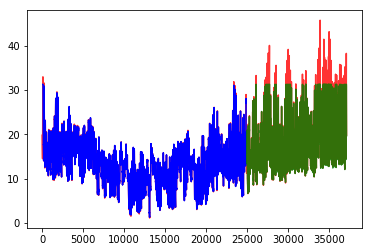

In [29]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), alpha=0.8, c='red')
plt.plot(trainPredictPlot, alpha=1, c='blue')
plt.plot(testPredictPlot, alpha=0.8, c='green')
plt.show()

#### Predict future temperature